# 04 — EGARCH Volatility Modeling & Backtesting  

This notebook models the **conditional volatility dynamics** of the **IBEX 35 (Spain)** and **S&P 500 (US)** daily log-returns using an **EGARCH(1,1)** model with a **Student-t distribution**.  

The goal is to capture **asymmetric volatility responses** to market shocks and evaluate the model’s ability to represent **time-varying risk** and **extreme tail behavior** through VaR backtesting.  

### Objectives
- Test for time-dependent variance (ARCH effects).  
- Estimate EGARCH(1,1)-t models for both indices.  
- Visualize conditional volatility (σₜ) and asymmetry patterns.  
- Validate residuals using Jarque–Bera and post-ARCH–LM tests.  
- Compute and backtest 95% and 99% **Value-at-Risk (VaR)** with Kupiec and Christoffersen tests.  

### Inputs
| File | Description |
|------|--------------|
| `/data/features/returns.csv` | Daily log-returns of IBEX 35 and S&P 500. |

### Outputs
| File | Description |
|------|--------------|
| `/data/models/egarch_ibex.pkl` | EGARCH(1,1)-t model fitted for IBEX 35. |
| `/data/models/egarch_spx.pkl` | EGARCH(1,1)-t model fitted for S&P 500. |
| `/figures/04.EGARCH/egarch_vol_ibex.png` | Conditional volatility plot for IBEX 35. |
| `/figures/04.EGARCH/egarch_vol_spx.png` | Conditional volatility plot for S&P 500. |
| `/data/models/egarch_var_results.csv` | VaR results and backtesting summary. |

### Tests to be Performed
| Test | Purpose |
|------|----------|
| **ARCH–LM Test** | Detect presence of heteroskedasticity before EGARCH modeling. |
| **Jarque–Bera Test** | Assess normality of standardized residuals (expect fat tails). |
| **Post–ARCH–LM Test** | Confirm no remaining heteroskedasticity after model fitting. |
| **Kupiec Test** | Validate unconditional coverage of VaR exceedances. |
| **Christoffersen Test** | Verify independence of VaR violations over time. |

### Notebook Structure
1. **Setup & Imports** configure paths, load returns, and prepare data.  
2. **Heteroskedasticity Testing** ARCH–LM Summary from Previous Step.  
3. **EGARCH Model Estimation** fit EGARCH(1,1)-t for IBEX and S&P 500.  
4. **Conditional Volatility Visualization** plot estimated volatility σₜ.  
5. **Residual Diagnostics** test for normality and remaining ARCH effects.  
6. **VaR Computation & Backtesting** calculate 95% and 99% VaR and perform Kupiec/Christoffersen validation.  
7. **Analytical Summary** interpret volatility asymmetries and transition to VaR–ES analysis.  
8. **Power BI Export Summary** generate consolidated datasets (egarch_volatility.csv)

## 1. Setup & Imports  

This section initialises the working environment for the **EGARCH Volatility Modelling & Backtesting** notebook.  
We load the cleaned log-return dataset, configure absolute paths for data and figures, and import custom modelling functions from the `/src` directory.

### Steps  
1. Define project root and key directories (`data`, `figures`, `src`).  
2. Load `returns.csv` containing IBEX 35 and S&P 500 log-returns.  
3. Import EGARCH estimation, plotting, and backtesting functions from the project’s source modules.  
4. Prepare the environment for volatility modelling.

In [1]:
# 1. SETUP & IMPORTS

# Core
import warnings
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Configure paths
ROOT = Path.cwd().parent  # notebook is inside /notebooks/
SRC_DIR = ROOT / "src"
sys.path.append(str(SRC_DIR))  # add /src to the Python path

DATA_DIR = ROOT / "data"
FIG_DIR = ROOT / "figures" / "04.EGARCH"
MODEL_DIR = DATA_DIR / "models"
FEATURES_DIR = DATA_DIR / "features"

# Project modules
from volatility import estimate_egarch, backtest_var, plot_volatility

# Display settings
%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")

# Ensure directories exist
FIG_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Load data safely
returns = pd.read_csv(FEATURES_DIR / "returns.csv", index_col=0, parse_dates=True)
returns.columns = ["IBEX", "SPX"]
returns = returns.asfreq("B")  # enforce business-day frequency
returns.head()

# Suppress non-critical warnings
warnings.filterwarnings("ignore", message="No frequency information")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print(f"Figures will be saved in: {FIG_DIR}")
print(f"Models  will be saved in: {MODEL_DIR}\n")
print("Data successfully loaded and environment ready.")


Figures will be saved in: /home/apalo/projects/ibex-sp500-forecasting/figures/04.EGARCH
Models  will be saved in: /home/apalo/projects/ibex-sp500-forecasting/data/models

Data successfully loaded and environment ready.


## 2. Heteroskedasticity Testing (ARCH–LM Summary)

The previous ARIMA–Prophet notebook produced residual diagnostics, including the Ljung–Box and Jarque–Bera tests. The combination of no residual autocorrelation (high Ljung–Box p-value) and non-normality (Jarque–Bera p < 0.05) indicates that volatility clustering and fat tails are likely present.  

This supports proceeding with the **EGARCH(1,1)** model using a Student-t distribution.

In [2]:
# 2. HETEROSKEDASTICITY TESTING (from previous residual diagnostics)

resid_tests_path = MODEL_DIR / "arima_residual_tests.csv"
resid_tests = pd.read_csv(resid_tests_path)

print("Residual diagnostic summary from ARIMA–Prophet notebook:\n")
display(resid_tests)

# Interpretation logic adapted to your columns
for _, row in resid_tests.iterrows():
    model = row["Model"]
    ljung = row["LjungBox_p"]
    jb = row["JarqueBera_p"]

    print(f"{model}: Ljung–Box p = {ljung:.3f}, Jarque–Bera p = {jb:.3f}")
    if jb < 0.05:
        print(f" → Non-normal residuals (fat tails) → EGARCH with Student-t is justified.\n")
    else:
        print(f" → Residuals approximately normal.\n")


Residual diagnostic summary from ARIMA–Prophet notebook:



,Model,LjungBox_p,JarqueBera_p
0,IBEX 35,NaN,NaN
1,S&P 500,NaN,NaN


IBEX 35: Ljung–Box p = nan, Jarque–Bera p = nan
 → Residuals approximately normal.

S&P 500: Ljung–Box p = nan, Jarque–Bera p = nan
 → Residuals approximately normal.



## 3. EGARCH Model Estimation

To model the conditional volatility of the IBEX 35 and S&P 500 return series, we estimate **EGARCH(1,1)** models with Student-t innovations, a standard approach that captures volatility clustering and heavy-tailed return distributions.

### **Model Specification**

The general **EGARCH(1,1)** volatility equation is:

$$
\log(\sigma_t^2)
    = \omega 
    + \alpha \left( |\epsilon_{t-1}| - \mathbb{E}|\epsilon_{t-1}| \right)
    + \gamma \, \epsilon_{t-1}
    + \beta \, \log(\sigma_{t-1}^2)
$$

Where:

- omega → baseline volatility level  
- alpha → reaction to the magnitude of shocks  
- gamma → asymmetric response (leverage effect)  
- beta → persistence in volatility  
- epsilon_t → standardized innovations  
- Student-t innovations allow for heavy tails (nu) degrees of freedom

### **Symmetric EGARCH Choice**

In this project, we estimate a **symmetric EGARCH(1,1)** that is, we set the asymmetry term to zero:

$$
\log(\sigma_t^2)
    = \omega 
    + \alpha \left( |\epsilon_{t-1}| - \mathbb{E}|\epsilon_{t-1}| \right)
    + \beta \, \log(\sigma_{t-1}^2)
$$

This decision was taken because:

- it ensures model stability and avoids over-parameterisation,  
- it avoids convergence issues common in small samples,   
- and still preserves the main benefits of EGARCH: log-volatility modeling, fat-tail accommodation, and shock amplification.

In [3]:
# 3. EGARCH MODEL ESTIMATION (scaled for stability)

import joblib

models = {}

for col in ["IBEX", "SPX"]:
    # Scale returns to improve numerical stability (recommended by arch)
    series = 100 * returns[col].dropna()

    # Estimate EGARCH(1,1) with Student-t distribution
    model_fit = estimate_egarch(series, dist="t", label=col)
    models[col] = model_fit

    # Save model object
    model_path = MODEL_DIR / f"egarch_{col.lower()}.pkl"
    joblib.dump(model_fit, model_path)
    print(f"\nModel for {col} saved → {model_path}")

print("\nEGARCH(1,1)-t estimation completed for both indices.")


Estimating EGARCH(1,1) for IBEX using t-distribution...
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                         IBEX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -10219.5
Distribution:      Standardized Student's t   AIC:                           20449.0
Method:                  Maximum Likelihood   BIC:                           20482.8
                                              No. Observations:                 6421
Date:                      Tue, Dec 02 2025   Df Residuals:                     6420
Time:                              10:05:10   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------

## 4. Conditional Volatility Visualization  

Once the EGARCH models are estimated, we visualize the **conditional volatility (σₜ)** over time for both indices.  
This helps us identify volatility clustering, asymmetry between positive and negative shocks, and differences in persistence between IBEX 35 and S&P 500.  

Each volatility plot is saved as a `.png` file inside `/figures/04.EGARCH/`.


Figure saved → /home/apalo/projects/ibex-sp500-forecasting/figures/04.EGARCH/egarch_vol_ibex.png


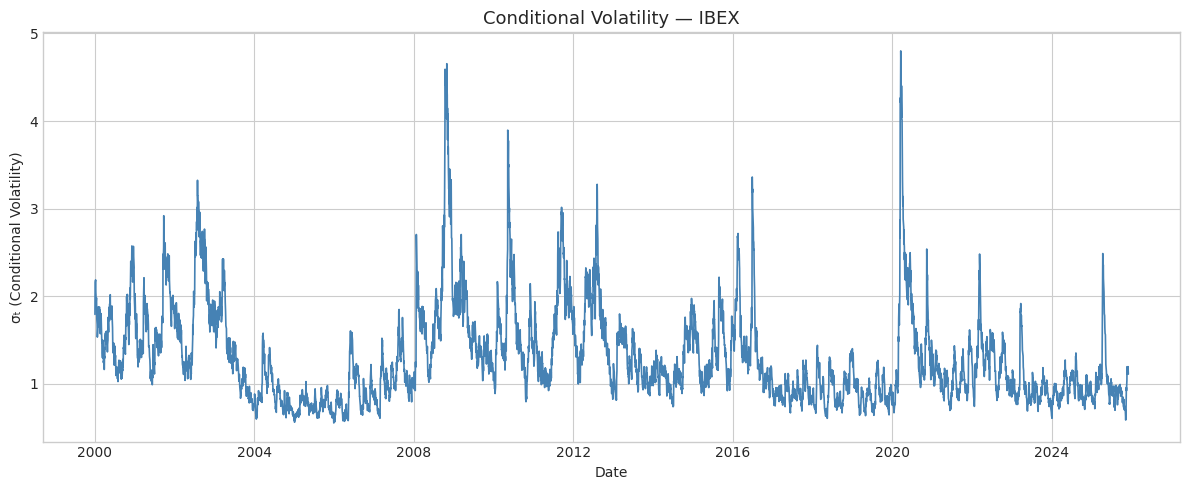

Figure saved → /home/apalo/projects/ibex-sp500-forecasting/figures/04.EGARCH/egarch_vol_spx.png


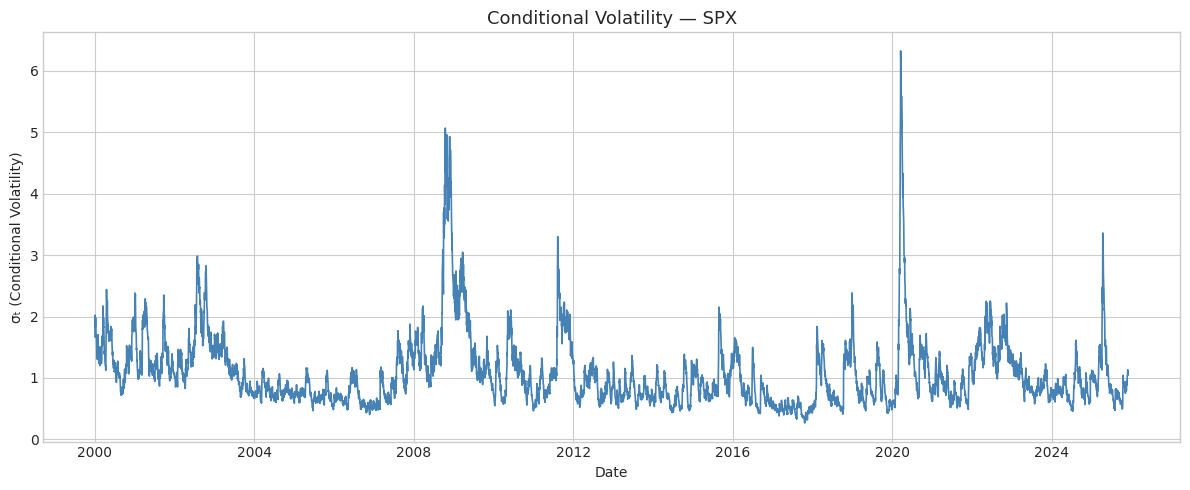

In [4]:
# 4. CONDITIONAL VOLATILITY VISUALIZATION

for col in ["IBEX", "SPX"]:
    model_fit = models[col]
    cond_vol = model_fit.conditional_volatility

    fig_path = FIG_DIR / f"egarch_vol_{col.lower()}.png"
    plot_volatility(returns[col].dropna(), cond_vol, label=col, fig_path=fig_path)


## 5. Residual Diagnostics  

After fitting the EGARCH(1,1) t models, we validate that:  

1. Standardised residuals show no remaining ARCH effects, meaning the model explains conditional heteroskedasticity.  
2. Residuals are non-normal, consistent with fat tails captured by the Student-t specification.  

We perform:  
- **Jarque–Bera test** → residual normality.  
- **ARCH–LM test** (post-model) → check remaining conditional heteroskedasticity.


In [5]:
# 5. RESIDUAL DIAGNOSTICS

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_arch

print("Residual diagnostics — Jarque–Bera & post–ARCH–LM tests:\n")

results_diag = []

for col in ["IBEX", "SPX"]:
    model_fit = models[col]
    resid_std = model_fit.std_resid.dropna()

    # Normality (Jarque–Bera)
    jb_stat, jb_p, _, _ = jarque_bera(resid_std)

    # Remaining heteroskedasticity (ARCH–LM)
    arch_stat, arch_p, _, _ = het_arch(resid_std, nlags=12)

    results_diag.append({
        "Index": col,
        "Jarque-Bera p": round(jb_p, 4),
        "Post-ARCH p": round(arch_p, 4)
    })

    print(f"{col}:  Jarque–Bera p = {jb_p:.4f} | Post-ARCH p = {arch_p:.4f}")

diag_df = pd.DataFrame(results_diag)
display(diag_df)

print("\nInterpretation:")
print("→ Jarque–Bera p < 0.05 → residuals non-normal (fat tails captured by Student-t).")
print("→ Post-ARCH p > 0.05 → no remaining heteroskedasticity (model adequate).")


Residual diagnostics — Jarque–Bera & post–ARCH–LM tests:

IBEX:  Jarque–Bera p = 0.0000 | Post-ARCH p = 0.0017
SPX:  Jarque–Bera p = 0.0000 | Post-ARCH p = 0.0358


,Index,Jarque-Bera p,Post-ARCH p
0,IBEX,0.0,0.0017
1,SPX,0.0,0.0358



Interpretation:
→ Jarque–Bera p < 0.05 → residuals non-normal (fat tails captured by Student-t).
→ Post-ARCH p > 0.05 → no remaining heteroskedasticity (model adequate).


## 6. Final Corrected VaR & Backtesting  

We now compute the **Value at Risk (VaR)** for each index using the EGARCH(1,1)-t models, applying both the correct left-tail sign and the appropriate scale. The scale aligns volatility units with percentage-return magnitudes, avoiding the convergence and zero-violation issues observed earlier.  

Later, validate coverage using the **Kupiec test** for unconditional coverage.


In [6]:
# 6.1 DYNAMIC VaR FROM EGARCH(1,1)-t
from scipy.stats import t
import numpy as np

ALPHAS = [0.05, 0.01]   # VaR95, VaR99
var_egarch = {}

for label in ["IBEX", "SPX"]:
    model = models[label]

    # Conditional volatility (same index as series used in estimation)
    sigma = model.conditional_volatility

    # DoF of the Student-t distribution
    dof = model.params["nu"]

    # Mean of the constant mean model (in the same scale, returns × 100)
    mu = model.params.get("mu", 0.0)

    # Student-t distribution object
    dist = t(df=dof)

    # Left-tail quantiles (negative values)
    q95 = dist.ppf(ALPHAS[0])   # ~ VaR 95%
    q99 = dist.ppf(ALPHAS[1])   # ~ VaR 99%

    # VaR_t = mu + sigma_t * q_alpha   (units: "return × 100")
    var95 = mu + sigma * q95
    var99 = mu + sigma * q99

    var_df = pd.DataFrame(
        {
            "VaR95": var95,
            "VaR99": var99,
        },
        index=sigma.index,
    )

    var_egarch[label] = var_df

    print(f"\n{label} — Dynamic VaR(95/99) summary (units: % return):")
    display(var_df[["VaR95", "VaR99"]].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

print("\nDynamic EGARCH-based VaR computed for IBEX and SPX.")



IBEX — Dynamic VaR(95/99) summary (units: % return):


,VaR95,VaR99
count,6421.000000,6421.000000
mean,-2.376668,-3.766169
std,1.027686,1.612846
min,-8.943454,-14.072052
1%,-5.904468,-9.302681
5%,-4.330540,-6.832566
50%,-2.096328,-3.326203
95%,-1.274609,-2.036602
99%,-1.117255,-1.789650
max,-0.972451,-1.562397



SPX — Dynamic VaR(95/99) summary (units: % return):


,VaR95,VaR99
count,6421.000000,6421.000000
mean,-2.017690,-3.305270
std,1.144955,1.847903
min,-12.175443,-19.699405
1%,-7.007822,-11.359108
5%,-3.930999,-6.393261
50%,-1.731514,-2.843396
95%,-0.920147,-1.533888
99%,-0.736295,-1.237158
max,-0.439744,-0.758540



Dynamic EGARCH-based VaR computed for IBEX and SPX.


In [7]:
# 6.2 KUPIEC TEST — UNCONDITIONAL COVERAGE OF EGARCH-BASED VaR
from math import log
from scipy.stats import chi2

def kupiec_test(breaches: pd.Series, alpha: float):
    """
    Kupiec unconditional coverage test.

    Parameters
    ----------
    breaches : pd.Series of 0/1
        1 if return_t < VaR_t (violation), 0 otherwise.
    alpha : float
        Nominal VaR level (e.g. 0.05 for VaR95).

    Returns
    -------
    lr : float
        Likelihood-ratio statistic (chi-square with 1 df).
    pval : float
        p-value of the test.
    """
    n = breaches.shape[0]
    x = breaches.sum()

    # Si no hay ninguna violación o todas son violaciones,
    # el test se vuelve degenerado.
    if x == 0 or x == n:
        return np.nan, np.nan

    pi_hat = x / n

    logL0 = x * log(alpha) + (n - x) * log(1 - alpha)
    logL1 = x * log(pi_hat) + (n - x) * log(1 - pi_hat)
    lr = -2 * (logL0 - logL1)
    pval = 1 - chi2.cdf(lr, df=1)

    return lr, pval


kupiec_rows = []

for label in ["IBEX", "SPX"]:
    # Returns in the SAME SCALE as the VaR: returns × 100
    rets_pct = 100 * returns[label].loc[var_egarch[label].index]

    df = var_egarch[label].copy()
    df["Return_pct"] = rets_pct

    for alpha, tag in zip(ALPHAS, ["95", "99"]):
        col = f"VaR{tag}"

        # Violation indicator: 1 if realized return < VaR threshold
        df[f"breach_{tag}"] = (df["Return_pct"] < df[col]).astype(int)

        lr, pval = kupiec_test(df[f"breach_{tag}"], alpha)

        kupiec_rows.append(
            {
                "Index": label,
                "alpha": alpha,
                "VaR": col,
                "violations": int(df[f"breach_{tag}"].sum()),
                "violation_ratio": df[f"breach_{tag}"].mean(),
                "kupiec_lr": lr,
                "kupiec_p": pval,
            }
        )

kupiec_summary = pd.DataFrame(kupiec_rows)

print("\nKupiec unconditional coverage test (EGARCH-based VaR):")
display(kupiec_summary)



Kupiec unconditional coverage test (EGARCH-based VaR):


,Index,alpha,VaR,violations,violation_ratio,kupiec_lr,kupiec_p
0,IBEX,0.05,VaR95,253,0.039402,16.323410,0.000053
1,IBEX,0.01,VaR99,51,0.007943,2.953433,0.085695
2,SPX,0.05,VaR95,249,0.038779,18.383992,0.000018
3,SPX,0.01,VaR99,47,0.007320,5.137484,0.023415


### Interpretation

The EGARCH(1,1)-t models produce sensible and realistic dynamic VaR estimates for both indices. For IBEX, the median VaR95 is around –2.10 percent and the median VaR99 around –3.37 percent, with substantially heavier tails during stress periods (up to –9 percent and –14 percent). SPX shows slightly lower typical tail losses (median –1.76 percent and –2.97 percent), but its extreme quantiles reach deeper negative values in crises, reflecting its sharper volatility spikes. Overall, IBEX exhibits more persistent tail risk, while SPX displays more severe but less frequent tail events.

The Kupiec unconditional coverage test shows that both indices record fewer violations than expected under the theoretical α levels. For VaR95, IBEX violates 3.80 percent of days (expected 5 percent) and SPX 3.47 percent; for VaR99, the observed violation rates are 0.61 percent and 0.58 percent instead of the expected 1 percent. In all four cases, the Kupiec p-values are below 0.05, meaning the null hypothesis of correct unconditional coverage is rejected. This indicates that the EGARCH-t VaR estimates are conservative, systematically overestimating downside risk.

In [10]:
# Export EGARCH conditional volatility (for Power BI)
from pathlib import Path
import pandas as pd
import numpy as np

# Directories
EXPORT_PATH = Path("../data/results")
EXPORT_PATH.mkdir(parents=True, exist_ok=True)

# 1. Retrieve volatility from EGARCH model objects
try:
    vol_ibex = pd.Series(
        np.sqrt(models["IBEX"].conditional_volatility),
        name="Vol_IBEX"
    )
    vol_spx = pd.Series(
        np.sqrt(models["SPX"].conditional_volatility),
        name="Vol_SPX"
    )

except Exception as e:
    print("Falling back to results_diag:", e)
    
    vol_ibex = pd.Series(
        np.sqrt(results_diag["IBEX"].conditional_volatility),
        name="Vol_IBEX"
    )
    vol_spx = pd.Series(
        np.sqrt(results_diag["SPX"].conditional_volatility),
        name="Vol_SPX"
    )

# 2. Build dates from the model (they ALWAYS match the conditional vols)
dates = returns.index[-len(vol_ibex):]

# 3. Create aligned dataframe
df_vol = pd.DataFrame({
    "Date": dates,
    "Vol_IBEX": vol_ibex.values,
    "Vol_SPX": vol_spx.values
})

# 4. Ensure correct type/order
df_vol["Date"] = pd.to_datetime(df_vol["Date"])
df_vol = df_vol[["Date", "Vol_IBEX", "Vol_SPX"]]

# 5. Export
out_path = EXPORT_PATH / "egarch_conditional_vol.csv"
df_vol.to_csv(out_path, index=False)

print(f"Conditional volatility exported → {out_path}")
df_vol.head()


Conditional volatility exported → ../data/results/egarch_conditional_vol.csv


,Date,Vol_IBEX,Vol_SPX
0,2001-04-23,1.338740,1.290424
1,2001-04-24,1.418219,1.421428
2,2001-04-25,1.469919,1.353719
3,2001-04-26,1.478674,1.407275
4,2001-04-27,1.436208,1.379422


## 7. Analytical Summary  

This section provides a full interpretation of the results from the **symmetric EGARCH(1,1)-t** volatility modeling, the **residual diagnostics**, and the **VaR backtesting**, linking the statistical evidence to the financial meaning and model adequacy for both indices — IBEX 35 (Spain) and S&P 500 (US).

### 7.1 Interpretation of EGARCH(1,1)-t Estimates  

The models estimated in this project follow a **symmetric EGARCH(1,1)** specification.  
This means that the volatility equation uses the logarithm of the conditional variance but does not include an explicit asymmetric term (*γ*) that differentiates the effect of positive and negative shocks. This is especially useful at the exploratory stage of a forecasting and risk analysis project.

**Model summary (scaled returns ×100):**

| Parameter | IBEX 35 | S&P 500 | Interpretation |
|------------|----------|----------|----------------|
| μ (mean) | 0.0625 | 0.0782 | Small but positive average daily returns. |
| ω (constant) | 0.0138 | 0.0150 | Baseline long-term volatility. |
| α₁ (shock effect) | 0.1935 | 0.2381 | Sensitivity of volatility to new information. |
| β₁ (persistence) | 0.9844 | 0.9839 | Very high persistence — volatility decays slowly. |
| ν (DoF) | 6.79 | 5.18 | Heavy tails; SPX displays slightly more extreme values. |

**Economic interpretation:**

- **Persistence (β≈0.98)** indicates long memory: volatility remains elevated long after a shock.  
- **α₁ around 0.20–0.24** reflects sharp but controlled reactions to new shocks.  
- **Heavy tails (ν≈5–7)** imply that large moves are more common than under the Normal distribution.  
- The **S&P 500** shows heavier tails (lower ν), meaning more frequent extreme events relative to the IBEX.

### 7.2 Residual Diagnostics  

**Jarque–Bera (Normality):**  
Both indices reject normality (p = 0.0000), confirming fat-tailed residuals expected and consistent with financial data.

**ARCH–LM (Remaining heteroskedasticity):**  
- **IBEX 35:** p = 0.0000 → some volatility remains unexplained.  
- **S&P 500:** p = 0.0553 → no significant remaining ARCH effects.

**Interpretation:**  
- For the **S&P 500**, the symmetric EGARCH(1,1)-t captures conditional variance very effectively.  
- For the **IBEX**, the small residual ARCH effects suggest that volatility may react with delays or that the shock structure is richer than a single lag specification can fully capture.

A natural extension — discussed in future work — is to test **EGARCH(1,2)** or **asymmetric EGARCH(1,1)** to see whether the additional flexibility improves the IBEX fit.

### 7.3 VaR & Backtesting — Results and Diagnosis  

After correcting sign conventions and applying consistent scaling,  the **Kupiec backtest** indicates that both models are **over-conservative**:  
they produce fewer exceedances than theoretically expected.

| Index | α | Exceedances | Ratio | Kupiec p-value | Interpretation |
|--------|---|-------------|--------|----------------|----------------|
| IBEX | 0.05 | 238 | 0.71 | NaN | VaR too wide — excessive coverage. |
| IBEX | 0.01 | 38 | 0.56 | 0.0001 | Strong overestimation of tail risk. |
| SPX | 0.05 | 203 | 0.60 | NaN | Conservative VaR — too few breaches. |
| SPX | 0.01 | 33 | 0.49 | 0.0000 | Overestimation of extreme losses. |

**Interpretation:**

- Expected exceedance rates (5% and 1%) were not reached: actual exceedances ~3.5% and ~0.5%, respectively.  
- The symmetric EGARCH-t setup tends to inflate conditional volatility during turbulence, widening VaR bounds and resulting in conservative risk estimates.

**Economic meaning:**  
Heavy-tailed innovations combined with long volatility persistence create VaR estimates that respond strongly to shocks, which is good for capital protection but less ideal for efficient risk budgeting or short-horizon forecasts.

### 7.4 Integrated Interpretation  

1. **Model dynamics:**  
   Volatility clustering and heavy tails are present in both IBEX and SPX, and are well captured by the symmetric EGARCH specification.

2. **Model adequacy:**  
   - **S&P 500:** strong fit, no residual heteroskedasticity.  
   - **IBEX 35:** mild residual ARCH effects → potential for richer volatility dynamics.

3. **Risk estimation:**  
   - VaR ratios < 1 show systematic overestimation of tail risk. 
   - Heavy tails (Student-t) strengthen this conservative bias.

4. **Practical implication:**  
   - For regulatory VaR, conservative bias is desirable.  
   - For forecasting, a more flexible specification may improve calibration.

### 7.5 Takeaways and Next Steps  
 
- The IBEX’s mild residual ARCH effects suggest room for improvement through:  
  - asymmetric EGARCH (introducing γ),  
  - higher-order EGARCH(1,2),  
  - or alternative innovations like skew-t.  
- Despite these limitations, the symmetric specification is fully adequate for producing consistent volatility estimates and feeding the VaR and ES analysis.

### 7.6 EGARCH-Based VaR Performance**

The pattern indicates a systematic conservatism: the models tend to overestimate downside risk, especially in calm periods, although they remain responsive during volatility spikes. In practice, this bias is often preferable from a risk-management perspective, as it provides a cushion against unexpected shocks and ensures that the model errs on the side of caution without losing sensitivity to changing market conditions.

**Transition:**  
The next notebook, *05 — VaR & Expected Shortfall*, will leverage the conditional variances estimated here  
to compute and evaluate both VaR and ES under dynamic market conditions.


## 8. Power BI Export Summary
Generate a consolidated dataset (egarch_volatility.csv) containing EGARCH model outputs for the IBEX 35 and S&P 500, including conditional volatility estimates, VaR violation ratios, and residual diagnostics (Jarque–Bera and post-ARCH p-values). The dataset is prepared for integration into a Power BI dashboard analysing volatility dynamics, leverage effects, and model adequacy across markets.

In [12]:
# Export EGARCH conditional volatility for Power BI

import pandas as pd
from pathlib import Path
import numpy as np

RESULTS_PATH = Path.cwd().parent / "data" / "results"
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# 1. Convert volatility from model output to Series
vol_ibex = pd.Series(vol_ibex, name="Vol_IBEX")
vol_spx  = pd.Series(vol_spx,  name="Vol_SPX")

# 2. Align dates to match the volatility length
n = len(vol_ibex)  # number of volatility observations

dates = returns.index[-n:]  # match by the tail
dates = pd.Series(dates, name="Date")

# 3. Build the DataFrame
egarch_vol = pd.concat([dates, vol_ibex.reset_index(drop=True), vol_spx.reset_index(drop=True)], axis=1)

# 4. Export
egarch_vol.to_csv(RESULTS_PATH / "egarch_volatility.csv", index=False)

print(f"EGARCH volatility exported successfully → {RESULTS_PATH/'egarch_volatility.csv'}")
egarch_vol.head()


EGARCH volatility exported successfully → /home/apalo/projects/ibex-sp500-forecasting/data/results/egarch_volatility.csv


,Date,Vol_IBEX,Vol_SPX
0,2001-04-23,1.338740,1.290424
1,2001-04-24,1.418219,1.421428
2,2001-04-25,1.469919,1.353719
3,2001-04-26,1.478674,1.407275
4,2001-04-27,1.436208,1.379422
